#**Skin Disease Classification**

Ilaria Tangorre 5307483 - Greta Riva 5306762

 **ResNet18 implementation - Skin Disease Classification**

 https://www.kaggle.com/datasets/pritpal2873/multiple-skin-disease-detection-and-classification

In [ ]:
!pip install d2l

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
d2l.use_svg_display()
import kagglehub

## **1. Loading data**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
resources = "drive/MyDrive/Colab Notebooks/RISORSE"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
path = kagglehub.dataset_download("pritpal2873/multiple-skin-disease-detection-and-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pritpal2873/multiple-skin-disease-detection-and-classification/versions/4


##**2. Data exploration**

In [ ]:
import os
print(os.listdir(path))

['Skin Cancer Dataset']


In [ ]:
main_folder = os.path.join(path, 'Skin Cancer Dataset')
print(os.listdir(main_folder))

['Basal Cell Carcinoma', 'Melanoma', 'Pigmented Benign Keratosis', 'Vascular Lesion', 'Acitinic Keratosis', 'Nevus', 'Squamous Cell Carcinoma', 'Dermatofibroma', 'Seborrheic Keratosis']


In [ ]:
class_counts = {}
for class_name in os.listdir(main_folder):
    class_path = os.path.join(main_folder, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print(class_counts)

{'Basal Cell Carcinoma': 500, 'Melanoma': 505, 'Pigmented Benign Keratosis': 500, 'Vascular Lesion': 290, 'Acitinic Keratosis': 500, 'Nevus': 500, 'Squamous Cell Carcinoma': 414, 'Dermatofibroma': 400, 'Seborrheic Keratosis': 500}


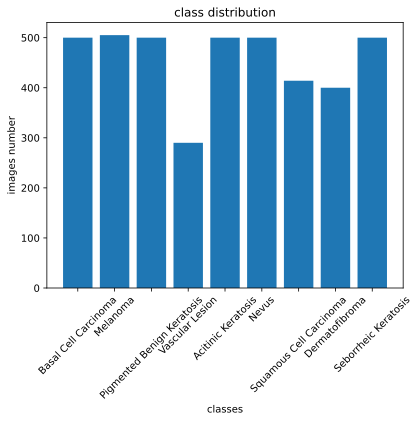

In [ ]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('classes')
plt.ylabel('images number')
plt.title('class distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from PIL import Image
import os
import random
main_folder = os.path.join(path, 'Skin Cancer Dataset')
def display_sample_images(main_folder, num_images=3):
    classes = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
    for class_name in classes:
        class_path = os.path.join(main_folder, class_name)
        images = os.listdir(class_path)
        sample_images = random.sample(images, min(num_images, len(images)))
        print(f"Classe: {class_name}")
        plt.figure(figsize=(10, 5))
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.show()
display_sample_images(main_folder)

In [ ]:
def check_image_sizes(main_folder):
    size_counts = {}
    for class_name in os.listdir(main_folder):
        class_path = os.path.join(main_folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        with Image.open(img_path) as img:
                            size = img.size
                            if size in size_counts:
                                size_counts[size] += 1
                            else:
                                size_counts[size] = 1
                    except Exception as e:
                        print(f"Errore nell'aprire il file {img_path}: {e}")

    #for size, count in size_counts.items():
        #print(f"Risolution {size}: {count} images")
#check_image_sizes(main_folder)

##**3. Data augmentation, normalization and oversampling**

To prepare the dataset, we applied data augmentation techniques such as resizing to 224x224 pixels, random rotations, flips, cropping, color adjustments, and Gaussian blur. These transformations increased variability, making the model more robust to input variations.

Normalization was performed using the calculated mean and standard deviation for the RGB channels to standardize pixel intensities. For the test set, we applied resizing and normalization to ensure consistency with the training data.

To address class imbalance, we implemented an oversampling strategy using a custom SkinCancerDataset class. This approach virtually replicates minority class samples by cycling through the dataset multiple times, controlled by an oversampling factor. Combined with augmentation, this ensures a more balanced and representative training process without physically altering the original dataset.

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

base_path = "/root/.cache/kagglehub/datasets/pritpal2873/multiple-skin-disease-detection-and-classification/versions/4"

test_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

sample_size = 500
image_tensors = []

image_paths = []
categories = os.listdir(main_folder)
for category in categories:
    category_path = os.path.join(main_folder, category)
    if os.path.isdir(category_path):
        image_paths.extend([
            os.path.join(category_path, img)
            for img in os.listdir(category_path)
            if img.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

sampled_images = random.sample(image_paths, min(len(image_paths), sample_size))
for img_path in sampled_images:
    try:
        img = Image.open(img_path).convert("RGB")
        tensor = test_augmentation(img)
        image_tensors.append(tensor)
    except Exception as e:
        print(f"Error with the image {img_path}: {e}")

stacked_images = torch.stack(image_tensors)
mean = stacked_images.mean(dim=[0, 2, 3])
std = stacked_images.std(dim=[0, 2, 3])

In [ ]:
mean=torch.tensor([0.6760, 0.5505, 0.5344])
stdev=torch.tensor([0.2002, 0.1920, 0.2010])
data_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.RandomRotation(degrees=20)], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
    transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.5),
    transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdev),
])

test_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdev)
])

In [ ]:
class SkinCancerDataset(data.Dataset):
    def __init__(self, dataset, transform=None, oversample_factor=5):
        self.dataset = dataset
        self.transform = transform
        self.oversample_factor = oversample_factor

    def __len__(self):
        return len(self.dataset) * self.oversample_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        image, label = self.dataset[original_idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
my_dataset = datasets.ImageFolder(root=main_folder, transform=data_augmentation)
my_dataset

Dataset ImageFolder
    Number of datapoints: 4107
    Root location: /root/.cache/kagglehub/datasets/pritpal2873/multiple-skin-disease-detection-and-classification/versions/4/Skin Cancer Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomApply(
               p=0.5
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
           )
               RandomApply(
               p=0.5
               RandomHorizontalFlip(p=1.0)
           )
               RandomApply(
               p=0.5
               RandomVerticalFlip(p=1.0)
           )
               RandomApply(
               p=0.5
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )
               RandomApply(
               p=0.5
               ColorJitter(brightness=(0.8, 1.2), contrast=

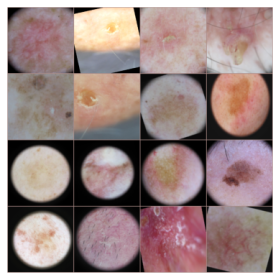

In [ ]:
import torchvision

def imshow(img, mean, std):
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

mean = [0.6760, 0.5505, 0.5344]
std = [0.2002, 0.1920, 0.2010]
images = [my_dataset[i][0] for i in range(16)]

grid_img = torchvision.utils.make_grid(images, nrow=4)
imshow(grid_img, mean, std)

##**4. Convolutional Neural Network**
###**ResNet18**

The ResNet18 (Residual Network 18) is a convolutional neural network architecture introduced in 2015 by Kaiming He et al. as part of the Residual Networks family. It consists of 18 trainable layers, including 3x3 convolutional filters, batch normalization, and ReLU activations, organized into residual blocks.

The key innovation lies in the use of shortcut connections, which allow the input to bypass one or more layers and be added directly to the output. This approach mitigates the performance degradation problem often encountered in very deep networks by enhancing gradient propagation during training. Each residual block applies convolutions and batch normalization followed by ReLU, while the residual addition simplifies the learning of transformations.

The ResNet18 implemented in this project follows the classic architecture of residual blocks, but with some modifications that enhance its robustness and adaptability. Each residual block combines 3x3 convolutions, batch normalization, and ReLU activations, maintaining the shortcut connections that allow the input flow to bypass certain layers and directly reach the output, preserving the principle of residual learning.
One of the main innovations is the inclusion of dropout within the residual blocks, with a probability of 0.3. This addition improves the model’s generalization ability, reducing the risk of overfitting.
The architecture is also more flexible thanks to the use of optional 1x1 convolutions, which are employed to realign dimensions in the residual blocks when needed. This increases the model’s ability to adapt to different dimensional configurations.

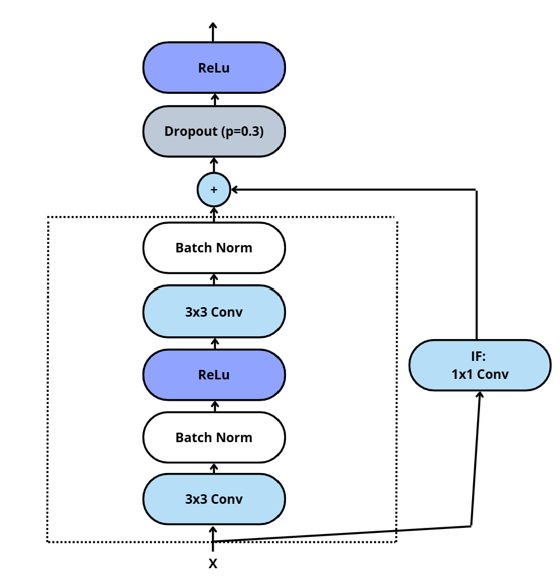

Additionally, the weights are initialized using the He initialization method for the convolutional layers, ensuring better convergence, while batch normalization parameters are initialized to constant values to ensure greater stability during training.
The make_layer function allows for easy construction of residual layers with customizable parameters, simplifying the scalability of the model.

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1, dropout_prob=0.3):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        Y = self.dropout(Y)
        return F.relu(Y)

X = torch.rand(4, 3, 64, 64)
residual_block = Residual(3, 3, use_1x1conv=True)

output = residual_block(X)
print(output.shape)

torch.Size([4, 3, 64, 64])


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=9, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, dropout_prob=dropout_prob)
        self.layer2 = self.make_layer(64, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.make_layer(128, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.make_layer(256, 512, 2, stride=2, dropout_prob=dropout_prob)

        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1, dropout_prob=0.3):
        layers = []
        layers.append(Residual(in_channels, out_channels, strides=stride, use_1x1conv=True, dropout_prob=dropout_prob))
        for _ in range(1, num_blocks):
            layers.append(Residual(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = ResNet18(num_classes=9, dropout_prob=0.3)
model.apply(initialize_weights)
X = torch.randn(8, 3, 64, 64)
model(X)

tensor([[ 1.7947,  0.8295, -3.1826,  0.4924, -0.0135, -0.0266,  1.9741, -2.8522,
          0.7287],
        [ 0.2740, -0.3206, -0.9700, -0.6856, -0.3588, -1.5606,  0.0338, -0.0057,
          2.0331],
        [-0.3157, -0.1721, -0.8849, -0.6683, -2.8928,  1.0436,  1.7396,  0.4419,
          0.0969],
        [-0.5816, -2.1704, -1.4757, -3.6286, -0.5131, -1.1357, -0.9741, -4.4792,
         -1.2150],
        [ 0.1617, -1.9858, -2.2637, -1.5553, -0.1996, -0.4068, -0.4138, -0.8146,
          3.5718],
        [-0.5484,  1.0790, -2.8731, -2.0864,  0.0371,  1.1667,  3.0026, -1.3223,
          0.2548],
        [ 0.5151,  1.7062, -1.9382, -1.0201, -0.5429, -0.6319,  0.3969, -1.5488,
         -0.1152],
        [ 1.7191, -0.7612, -2.6012, -1.8535, -1.2735,  2.4679,  1.7924, -1.0134,
          0.7514]], grad_fn=<AddmmBackward0>)

##**5. Evaluate accuracy and training function**
We trained the ResNet18 using the Adam optimizer, selected for its ability to adjust the learning rate dynamically for each parameter, which ensures faster and more stable convergence. Cross Entropy Loss was used to measure the divergence between predicted probabilities and the true labels, penalizing larger errors more heavily, making it particularly effective for multi-class classification tasks.

The training process involves a forward pass to calculate predictions and the loss, followed by a backward pass, where the weights are updated via backpropagation to minimize the loss function iteratively. During the training, the model saves the weights that correspond to the best validation accuracy, ensuring that the most performant version is kept at the end.

In [ ]:
from tqdm import tqdm

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, val_iter, num_epochs, lr,
          device=d2l.try_gpu(), save_path="best_model.pth"):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    print('training on', device)

    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    best_val_acc = 0
    timer, num_batches = d2l.Timer(), len(train_iter)
    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.item() * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter, device)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(net.state_dict(), save_path)
        animator.add(epoch + 1, (None, None, val_acc))
        progress_bar.set_description(f'loss {train_l:.3f}, train acc {train_acc:.3f}, val acc {val_acc:.3f}, best val acc {best_val_acc:.3f}')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {val_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

##**6. Dataset preparation for training**
We split the image dataset into three subsets: training, validation, and testing, using the train_test_split function from sklearn. 70% of the data is allocated for training, while 30% is used for testing. The test set is then further divided into two equal parts to create the validation set.

To improve the model's generalization ability, we applied an oversampling factor of 5 to the training dataset, as defined in the SkinCancerDataset class. This helps balance the classes in the training set. On the other hand, the oversampling factor was set to 1 for the test and validation sets, leaving them unchanged. This approach was chosen to optimize the model's learning, especially for underrepresented classes.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

my_dataset = datasets.ImageFolder(root=main_folder, transform=transforms.Resize((224, 224)))
train_dataset, test_dataset = train_test_split(my_dataset, test_size=0.3, random_state=SEED)
test_dataset, val_dataset = train_test_split(test_dataset, test_size=0.5, random_state=SEED)
train_dataset = SkinCancerDataset(train_dataset, transform=data_augmentation, oversample_factor=5)
test_dataset = SkinCancerDataset(test_dataset, transform=test_augmentation, oversample_factor=1)
val_dataset = SkinCancerDataset(val_dataset, transform=test_augmentation, oversample_factor=1)
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
total_size = train_size + val_size + test_size


print(f"Training examples: {train_size}")
print(f"Validation examples: {val_size}")
print(f"Testing examples: {test_size}")

Training examples: 14370
Validation examples: 617
Testing examples: 616


In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for images, labels in train_loader:
    print(f"Batch shape: {images.size()}")
    print(f"Labels: {labels}")
    break

Batch shape: torch.Size([16, 3, 224, 224])
Labels: tensor([6, 0, 3, 7, 6, 3, 3, 8, 4, 8, 8, 5, 3, 5, 2, 1])


<ipython-input-40-6f79c87716ce>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std)[:, None, None]


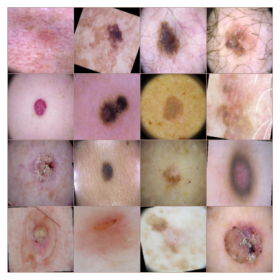

In [ ]:
import torchvision
images = next(iter(train_loader))[0][:16]
grid_img = torchvision.utils.make_grid(images, nrow=4)
imshow(grid_img, mean, stdev)

##**7. Training**

In [ ]:
lr, num_epochs = 0.01, 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=9, dropout_prob=0.3)
model = model.to(device)
#train(model, train_loader, val_loader, num_epochs, lr, device)

loss 0.532, train acc 0.808, val acc 0.541, best val acc 0.562

output (1).svg

##**8. Performance evaluation**
We loaded the ResNet18 model with the trained weights, set it to evaluation mode, and ran it on the test dataset. The true labels and predictions were collected for each batch, and then used to calculate performance metrics, like accuracy and the confusion matrix.



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=9, dropout_prob=0.3)
model.eval()
model.load_state_dict(torch.load(resources+'/best_model.pth', weights_only=True, map_location=device)) #loading trained model
model = model.to(device)

Y_true = []
Y_pred = []
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    y_hat = model(X)
    Y_pred.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
    Y_true.extend(y.cpu().numpy())

accuracy:  0.5844155844155844


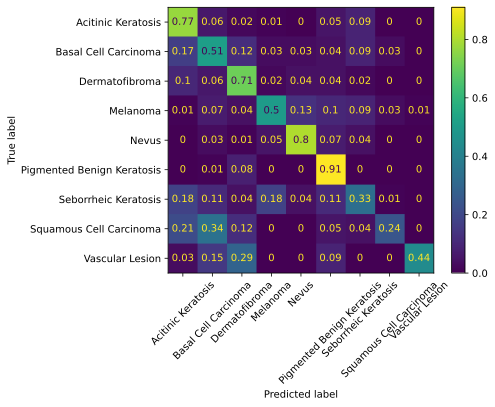

In [ ]:
#Confusion matrix
acc = accuracy_score(Y_true, Y_pred)
conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true') #Normalized confusion matrix
report = classification_report(Y_true, Y_pred, target_names=my_dataset.classes)
conf_mat = np.round(conf_mat, 2)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=my_dataset.classes)
disp.plot(xticks_rotation=45)
print("accuracy: ", acc)

##**Conclusion**
The goal of this project was to develop a model capable of classifying skin disease images using a deep learning architecture. For this task, we used the "multiple-skin-disease-detection-and-classification" image dataset, which contains 4107 images divided into various categories. Unfortunately, the limited number of images posed one of the main challenges, which hindered the achievement of optimal results.

During the process, we applied several pre-processing techniques and dataset modifications, such as oversampling to balance the underrepresented classes, allowing the model to generalize better. The final accuracy achieved was 0.58. While this is not an excellent result, it aligns with the small size of the initial dataset. The results show that the model performed better with classes containing a larger number of images, such as "Pigmented benign Keratosis" (TP = 0.91), "Nevus" (TP = 0.8), and "Actinic Keratosis" (TP = 0.77). However, it struggled with correctly classifying classes like "Squamous Cell Carcinoma" (TP = 0.24) and "Seborrheic Keratosis" (TP = 0.33), suggesting that further improvements could be made with more data and advanced models.

In the future, we plan to explore more sophisticated architectures and expand the dataset with higher-quality images to further improve accuracy and reduce errors in the underrepresented classes. With model evolution and dataset expansion, we are confident that more accurate and reliable results for automatic skin disease diagnosis can be achieved.